In [191]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
import time
from yahooquery import Ticker
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 9999)
pd.set_option('display.max_rows', 9999)

### Import Trades from file generated by code and create Prices dataframe

In [192]:
# Read generated buys
trades = pd.read_csv('../output/trades.csv')
trades['just_date'] = pd.to_datetime(trades['just_date'])
business_days = [pd.Timestamp(date.astype(datetime)) for date in list(trades['just_date'].unique())]

In [193]:
trades.head()

symbol  just_date  close_price_x buy_signal?1 sell_signal?1 buy_signal?2  \
0  BIO-B 2016-01-26     126.239998          NaN           NaN          NaN   
1  BIO-B 2016-01-27     126.239998          NaN           NaN          NaN   
2  BIO-B 2016-01-28     126.239998          NaN           NaN          NaN   
3  BIO-B 2016-01-29     126.239998          NaN           NaN          NaN   
4  BIO-B 2016-02-01     126.989998          NaN           NaN          NaN   

  sell_signal?2 buy_signal?3 sell_signal?3 buy_signal?4 sell_signal?4  \
0           NaN          NaN           NaN          NaN           NaN   
1           NaN          NaN           NaN          NaN           NaN   
2           NaN          NaN           NaN          NaN           NaN   
3           NaN          NaN           NaN          NaN           NaN   
4           NaN          NaN           NaN          NaN           NaN   

  buy_signal?5 sell_signal?5  
0          NaN           NaN  
1          NaN           NaN  
2          NaN           NaN  
3          NaN           NaN  
4          NaN           NaN

### Import Earnings

In [194]:
# Read Earnings
earnings = pd.read_csv('../docs/earnings.csv')
earnings['earnings_date_90d'] = pd.to_datetime(earnings['earnings_date']) - timedelta(days=90)

# Merge with trades
trades = pd.merge(trades, earnings, how='left', left_on=['symbol', 'just_date'], right_on=['symbol', 'earnings_date_90d'])
trades['earnings_date'] = trades.groupby(['symbol']).ffill()['earnings_date']
trades['earnings_date'] = pd.to_datetime(trades['earnings_date'])
trades['earnings_difference'] = trades['just_date'] - trades['earnings_date']
trades['earnings_difference'] = trades['earnings_difference'].dt.days

# Add Previous day price column for Trailing Loss calculation
trades['previous_day_price'] = trades.groupby(['symbol']).shift(1)['close_price_x']

# Drop Columns
trades.drop(columns=['earnings_date_90d', 'earnings_date'], inplace=True)

## S&P

In [365]:
sp = Ticker('SPY')
sp = sp.history(start='2016-01-01', interval='1d')
sp['daily_returns'] = sp['close'].pct_change()
sp['daily_returns'] = sp['daily_returns'] + 1
sp['running_return'] = sp['daily_returns'].cumprod() - 1
sp = sp.reset_index()
sp['index'] = pd.to_datetime(sp['index']).dt.date
sp = sp.set_index('index')

### Create DataFrames of Buys and Sells
#### Buys

In [196]:
def extract_buys(df, pair_of_signals, buy_date, how_much, balances):
    
    # Create empty list to store results
    buys_list = []
    
    # Final balances
    final_balances = []
    
    # Columns
    columns_list = ['symbol', 'date', 'price', 'order_type', 'shares', 'total', 'strategy']
    
    # Empty dataframe
    empty_df = pd.DataFrame([[0,0,0,0,0,0]], columns = ['symbol', 'date', 'price', 'order_type', 'shares', 'total'])
    
    # Loop through different strategies
    for idx, item in enumerate(pair_of_signals):
        
        #Define buy and sell signals
        buy_signal = item[0]
        sell_signal = item[1]
        
        # Reset exclude symbols
        exclude_symbols = []
        
        # Initial balance
        current_balance = balances[idx]
        
        # Calculate how_much
        
        
        # Create dataframe with buys
        buys = df[(df['just_date'] == buy_date) 
                    & (df[buy_signal] == True)
                    & (df[sell_signal] != True)
                    & (~df['earnings_difference'].between(-5,-1))][['symbol', 'just_date', 'close_price_x']]
        
        # Check if there's enough money to buy
        for index, row in buys.iterrows():
            if current_balance >= how_much:
                current_balance = current_balance - how_much
            else:
                exclude_symbols.append(row['symbol'])
        
        # Remove excluded symbols
        if len(exclude_symbols) > 0:
            buys = buys[~buys['symbol'].isin(exclude_symbols)]
        
        # Create some other columns
        buys['order_type'] = 'buy'
        buys['shares'] = how_much / buys['close_price_x']
        buys['total'] = buys['shares'] * buys['close_price_x']
        buys['strategy'] = buy_signal
        
        # Append current balance
        final_balances.append(current_balance)
        
        # If length is zero then create empty record
        if len(buys) == 0:
            buys_none = empty_df
            buys_none['strategy'] = buy_signal
            buys_list.append(buys_none.values.tolist()[0])
            
        # Else then append buys
        else:
            buys.columns = columns_list
            [buys_list.append(i) for i in buys.values.tolist()]
    
    # Transform list into a Dataframe
    buys_df = pd.DataFrame(buys_list, columns = columns_list)

    return buys_df, final_balances

### Sells

In [369]:
def extract_sells(trades, date, sell_signal):
    # Search for the sell_signal on a given day
    sells = trades[(trades['just_date'] == date) 
                & (trades[sell_signal] == True)][['symbol', 'just_date', 'close_price_x']]
    
    # Create Column with order type
    sells['order_type'] = 'sell'
    
    # Rename a columns
    sells.columns = ['symbol', 'sell_date', 'price', 'order_type']
    
    return sells

### Loop Through Days
Logic:
- See if there are any buys on that day and add to holdings_df if that's the case.
- See if there are any sells using the sell_signal and limits (max_loss and max_holdings).
- If you have sells, then remove them from holdings and add to rgl_df.

In [413]:
# Define Min, Max and Moving Dates
min_date = trades['just_date'].min()
max_date = trades['just_date'].max()

# Custom Dates
start_date = '2017-01-02'
min_date = pd.to_datetime(start_date)
end_date = '2019-09-30'
max_date = pd.to_datetime(end_date)

number_of_days = (max_date - min_date).days + 1
count = 1

# Result Lists
holdings_list = []
rgl_list = []

# The moving date gives sells/buys on a given day.
moving_date = min_date

# List of buy signals to be analyzed
pair_of_signals = [ ('buy_signal?1', 'sell_signal?1'),
#                    ('buy_signal?2', 'sell_signal?2'),
#                    ('buy_signal?3', 'sell_signal?3'),
                    ('buy_signal?4', 'sell_signal?4')]
#                   ,
#                    ('buy_signal?5', 'sell_signal?5')]

# Balances
initial_balances = [5000 for i in range(len(pair_of_signals))]
list_of_balances = []

# How much to add every month
more_cash = [0 for i in range(len(pair_of_signals))]
how_much = 100

# Max loss and holdings
max_loss = -0.05
max_loss_perc = 0.05
max_holdings = 90                

# Max Gain
max_gain = 0.10

# calendar
calendar = []

# While moving date is less or equal to max_date
while moving_date <= max_date:
    
    # On the first day of the month we will add more 100 bucks
    if (moving_date.day == 1) & (moving_date != start_date):
        # Add cash every month
        current_balances = [x + y for x, y in zip(current_balances, more_cash)]
    
    # Add to calendar
    calendar.append(moving_date)
    
    # Start tracking time
    start_time = time.time()
    
    # If it's the first date, the process is different, because holdings and rgl need to be created yet
    if moving_date == min_date:
        
        # Figure out buys
        buys, current_balances = extract_buys(trades, pair_of_signals=pair_of_signals, buy_date=moving_date, how_much=how_much, balances=initial_balances)
        
        # Create holdings
        holdings_df = buys[['strategy', 'date', 'symbol', 'price', 'shares', 'total']]
        holdings_df.columns = ['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 'cost_basis']
        
        # As of Date and close_price columns
        holdings_df['as_of_date'] = moving_date
        holdings_df['day_close_price'] = 0
        holdings_df['market_value'] = 0
        holdings_df['gains_$'] = 0
        
        # Convert symbols to string to avoid merging problems in the future
        holdings_df['symbol'] = holdings_df['symbol'].astype(str)
        
        # Holdings append
        holdings_list.append(holdings_df.values.tolist())
                
        # Create RGL
        rgl_df = holdings_df.copy()
        rgl_list.append(rgl_df.values.tolist())
                
    # If it's not the first day:
    else:
        
        # Create prices dataframe from trades
        prices = trades[trades['just_date'] == moving_date][['symbol', 'close_price_x']]
        prices.columns = ['symbol', 'day_close_price']
        
        # Get Previous Day's Holdings and store the number of securities held on that day
        
        #previous_holdings = temp_holdings[temp_holdings['as_of_date'] == previous_day]
        previous_holdings = pd.DataFrame(holdings_list[-1])
        previous_holdings.columns = ['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 
                                     'cost_basis', 'date', 'previous_price', 'mkt', 'gain']
        previous_holdings = previous_holdings[['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 
                                     'cost_basis', 'previous_price']]
        #previous_holdings = previous_holdings.drop('day_close_price', axis=1)
        #previous_holdings.drop(['as_of_date'], axis=1, inplace=True)
        
        # Create Temporary RGL List to Append results from each strategy
        rgl_temp = []
        holdings_temp = []
        temp_balances = []
        
        # Loop through different strategies
        for idx, item in enumerate(pair_of_signals):
            
            #Signals
            buy_signal = item[0]
            sell_signal = item[1]
            
            # Reset value of sell
            money_from_sell = 0
            
            # Strategy Holdings
            strategy_holdings = previous_holdings[previous_holdings['strategy'] == buy_signal]
            
            # Check the number of Holdings symbols in a given strategy
            number_of_symbols = len(strategy_holdings['symbol'].unique())
        
            # Figure out sells and create list of symbols with sell signals
            sells = extract_sells(trades, moving_date, sell_signal=sell_signal)
            sold_symbols = set(sells['symbol'])
        
            # Remove sells from Previous Day's Holdings
            holdings_no_sells = strategy_holdings[~strategy_holdings['symbol'].isin(sold_symbols)]
        
            # Do the following with the securities that were left (only in business days)
            if moving_date in business_days:
                
                # See which companies are about to announce earnings (we don't want to hold that)
                earnings['moving_date'] = moving_date
                max_date_earnings = moving_date + timedelta(days=5)
                earnings['moving_date'] = pd.to_datetime(earnings['moving_date'])
                earnings['earnings_date'] = pd.to_datetime(earnings['earnings_date'])
                earnings['diff'] = earnings['earnings_date'] - earnings['moving_date']
                earnings['diff'] = earnings['diff'].dt.days
                announcing_earnings = set(earnings[(earnings['earnings_date'] > moving_date) & (earnings['earnings_date'] < max_date_earnings)]['symbol'])
                
                # Create new sell signals based on max_loss and max_holdings
                # Calculate % gain
                stop_loss_sells = pd.merge(holdings_no_sells, prices, on='symbol', how='left')
                stop_loss_sells['market_value'] = stop_loss_sells['shares'] * stop_loss_sells['day_close_price']
                stop_loss_sells['%_gain'] = (stop_loss_sells['market_value'] / stop_loss_sells['cost_basis']) - 1
                stop_loss_sells['daily_difference'] = stop_loss_sells['day_close_price'] - stop_loss_sells['previous_price']
            
                # Create column with date and remove 0's from sells
                stop_loss_sells['just_date'] = moving_date
                stop_loss_sells = stop_loss_sells[stop_loss_sells['buy_date'] != 0]
                
                # If sell signals were generated from this, then do the following
                if len(stop_loss_sells) > 0:
                
                    # Calculate the number of Holding Days, which is the difference between buy_date and just_date
                    stop_loss_sells['holding_days'] = (stop_loss_sells['just_date'] - pd.to_datetime(stop_loss_sells['buy_date']))
                    stop_loss_sells['holding_days'] = stop_loss_sells['holding_days'].dt.days
                
                    # Create Sell Signal if % gain is below max_loss OR holding_days is greater then max_holdings
                    stop_loss_sells = stop_loss_sells[
                        (stop_loss_sells['%_gain'] < max_loss)
                       |(stop_loss_sells['%_gain'] > max_gain)
                       |(stop_loss_sells['holding_days'] > max_holdings)
                       |(stop_loss_sells['symbol'].isin(announcing_earnings))
                       |(stop_loss_sells['daily_difference'] < (how_much * max_loss_perc * -1))][['symbol', 'just_date', 'day_close_price']]
                    
                    # Create order_type column and rename columns
                    stop_loss_sells['order_type'] = 'sell'
                    stop_loss_sells.columns = ['symbol', 'sell_date', 'price', 'order_type']

                    # Concatenate new sells with sells generated from sell_signal? 
                    sells = pd.concat([sells, stop_loss_sells]).drop_duplicates()

                    # Create list of sold symbols
                    sold_symbols = set(sells['symbol'])

                # Remove sells from Previous Day's Holdings, again. This time including sells from loss and holding limits
                holdings_no_sells = strategy_holdings[~strategy_holdings['symbol'].isin(sold_symbols)]
                
            
            # Remove column of previous price
            holdings_no_sells = holdings_no_sells[['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 
                                     'cost_basis']]
            
            # Append results into holdings_temp
            [holdings_temp.append(i) for i in holdings_no_sells.values.tolist()]
        
            # Store Realized Gains/Losses in rgl_df only if there are symbols in sold_symbols
            if len(sold_symbols) > 0:
                
                # Remove column of previous price
                strategy_holdings = strategy_holdings[['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 
                                     'cost_basis']]

                # Create Dataframe by merging Previous Day's Holdings with sells dataframe
                today_rgl = pd.merge(strategy_holdings, sells, how='inner', on='symbol')

                # Get prices in which the securities were sold
                today_rgl = pd.merge(today_rgl, prices, how='left', on='symbol')

                # Create as of date column and calculate gains and market value
                today_rgl['as_of_date'] = moving_date
                today_rgl['market_value'] = today_rgl['shares'] * today_rgl['day_close_price']
                today_rgl['$_gain'] = today_rgl['market_value'] - today_rgl['cost_basis']
                today_rgl['%_gain'] = (today_rgl['market_value'] / today_rgl['cost_basis']) - 1

                # Add that into master rgl_df
                #rgl_df = pd.concat([rgl_df, today_rgl])
                if len(today_rgl) > 0:
                    rgl_temp.append(today_rgl.values.tolist())
                    money_from_sell = today_rgl[today_rgl['strategy'] == buy_signal].sum()['market_value']
            
            # Append results in temp_balance
            temp_balances.append(money_from_sell)        
        
        # New Current balance
        current_balances = [x + y for x, y in zip(current_balances, temp_balances)]
        
        # Append results into rgl_list
        [rgl_list.append(i) for i in rgl_temp]
        
        # Now that sold securities have been removed from holdings, it's time to look for buys
        buys, current_balances = extract_buys(trades, pair_of_signals=pair_of_signals, buy_date=moving_date, how_much=how_much, balances=current_balances)
        buys = buys[['strategy', 'date', 'symbol', 'price', 'shares', 'total']]
        buys.columns = ['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 'cost_basis']
        
        # Add Buys to holdings
        columns = holdings_no_sells.columns
        holdings_data_frame = [i for i in holdings_temp]
        holdings_no_sells_temp = pd.DataFrame(holdings_data_frame, columns=columns)
        today = pd.concat([holdings_no_sells_temp, buys])
        today = today.drop_duplicates()
        today['as_of_date'] = moving_date
         
        # Number of Symbols in new holdings (Previous Day's minus sells, plus new buys)
        number_of_symbols = len(today['symbol'].unique())
        
        # If you have more than one security (there's a placeholder, so we need more than one)
        # Then pull prices to calculate market value and % gain
        if number_of_symbols > 1:
            today = pd.merge(today, prices, on='symbol', how='left')
            today['market_value'] = today['shares'] * today['day_close_price']
            today['%_gain'] = (today['market_value'] / today['cost_basis']) - 1
        
        # Append with master holdings
        #holdings_df = holdings_df.append(today)
        holdings_list.append(today.values.tolist())
        
        # Create list with balances
        balance_day = current_balances
        balance_day.append(moving_date)
        list_of_balances.append(balance_day)
        
        # Completion %
        print(str(round((100 * count / number_of_days),2)) + ' % - ' + str(round(time.time() - start_time, 1)) + ' seconds')
    
    # Previous day becomes moving_date and moving date becomes moving date plus one day
    previous_day = moving_date
    moving_date += timedelta(days=1)
    count += 1

0.2 % - 0.3 seconds
0.3 % - 0.3 seconds
0.4 % - 0.3 seconds
0.5 % - 0.3 seconds
0.6 % - 0.2 seconds
0.7 % - 0.2 seconds
0.8 % - 0.3 seconds
0.9 % - 0.3 seconds
1.0 % - 0.3 seconds
1.1 % - 0.3 seconds
1.2 % - 0.3 seconds
1.3 % - 0.2 seconds
1.4 % - 0.2 seconds
1.5 % - 0.2 seconds
1.6 % - 0.3 seconds
1.7 % - 0.3 seconds
1.8 % - 0.3 seconds
1.9 % - 0.3 seconds
2.0 % - 0.2 seconds
2.1 % - 0.2 seconds
2.2 % - 0.3 seconds
2.3 % - 0.3 seconds
2.4 % - 0.3 seconds
2.5 % - 0.3 seconds
2.59 % - 0.3 seconds
2.69 % - 0.2 seconds
2.79 % - 0.2 seconds
2.89 % - 0.3 seconds
2.99 % - 0.3 seconds
3.09 % - 0.3 seconds
3.19 % - 0.3 seconds
3.29 % - 0.3 seconds
3.39 % - 0.2 seconds
3.49 % - 0.3 seconds
3.59 % - 0.3 seconds
3.69 % - 0.3 seconds
3.79 % - 0.3 seconds
3.89 % - 0.3 seconds
3.99 % - 0.3 seconds
4.09 % - 0.2 seconds
4.19 % - 0.2 seconds
4.29 % - 0.3 seconds
4.39 % - 0.3 seconds
4.49 % - 0.3 seconds
4.59 % - 0.3 seconds
4.69 % - 0.3 seconds
4.79 % - 0.2 seconds
4.89 % - 0.2 seconds
4.99 % - 0.2 sec

37.92 % - 0.3 seconds
38.02 % - 0.3 seconds
38.12 % - 0.3 seconds
38.22 % - 0.3 seconds
38.32 % - 0.3 seconds
38.42 % - 0.2 seconds
38.52 % - 0.3 seconds
38.62 % - 0.3 seconds
38.72 % - 0.3 seconds
38.82 % - 0.3 seconds
38.92 % - 0.3 seconds
39.02 % - 0.2 seconds
39.12 % - 0.2 seconds
39.22 % - 0.3 seconds
39.32 % - 0.3 seconds
39.42 % - 0.3 seconds
39.52 % - 0.3 seconds
39.62 % - 0.3 seconds
39.72 % - 0.2 seconds
39.82 % - 0.2 seconds
39.92 % - 0.3 seconds
40.02 % - 0.3 seconds
40.12 % - 0.3 seconds
40.22 % - 0.3 seconds
40.32 % - 0.3 seconds
40.42 % - 0.2 seconds
40.52 % - 0.2 seconds
40.62 % - 0.3 seconds
40.72 % - 0.3 seconds
40.82 % - 0.3 seconds
40.92 % - 0.3 seconds
41.02 % - 0.3 seconds
41.12 % - 0.2 seconds
41.22 % - 0.2 seconds
41.32 % - 0.2 seconds
41.42 % - 0.3 seconds
41.52 % - 0.3 seconds
41.62 % - 0.3 seconds
41.72 % - 0.3 seconds
41.82 % - 0.2 seconds
41.92 % - 0.2 seconds
42.02 % - 0.3 seconds
42.12 % - 0.3 seconds
42.22 % - 0.3 seconds
42.32 % - 0.3 seconds
42.42 % - 

75.35 % - 0.2 seconds
75.45 % - 0.2 seconds
75.55 % - 0.3 seconds
75.65 % - 0.3 seconds
75.75 % - 0.3 seconds
75.85 % - 0.3 seconds
75.95 % - 0.3 seconds
76.05 % - 0.2 seconds
76.15 % - 0.2 seconds
76.25 % - 0.3 seconds
76.35 % - 0.3 seconds
76.45 % - 0.3 seconds
76.55 % - 0.3 seconds
76.65 % - 0.3 seconds
76.75 % - 0.2 seconds
76.85 % - 0.2 seconds
76.95 % - 0.3 seconds
77.05 % - 0.3 seconds
77.15 % - 0.3 seconds
77.25 % - 0.3 seconds
77.35 % - 0.3 seconds
77.45 % - 0.2 seconds
77.54 % - 0.2 seconds
77.64 % - 0.2 seconds
77.74 % - 0.3 seconds
77.84 % - 0.3 seconds
77.94 % - 0.3 seconds
78.04 % - 0.3 seconds
78.14 % - 0.2 seconds
78.24 % - 0.2 seconds
78.34 % - 0.3 seconds
78.44 % - 0.3 seconds
78.54 % - 0.3 seconds
78.64 % - 0.3 seconds
78.74 % - 0.3 seconds
78.84 % - 0.2 seconds
78.94 % - 0.2 seconds
79.04 % - 0.3 seconds
79.14 % - 0.3 seconds
79.24 % - 0.3 seconds
79.34 % - 0.3 seconds
79.44 % - 0.3 seconds
79.54 % - 0.3 seconds
79.64 % - 0.2 seconds
79.74 % - 0.3 seconds
79.84 % - 

## Daily Holdings

In [414]:
data_frame_list = [x for b in holdings_list for x in b]
holdings_df = pd.DataFrame(data_frame_list)
holdings_df.columns = ['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 'cost_basis', 'as_of_date', 'day_close_price', 'market_value', '%_gain']
holdings_df['$_gain'] = holdings_df['market_value'] - holdings_df['cost_basis']
holdings_df[holdings_df['symbol'] == 'VIVO'].tail()


Empty DataFrame
Columns: [strategy, buy_date, symbol, cost_per_unit, shares, cost_basis, as_of_date, day_close_price, market_value, %_gain, $_gain]
Index: []

## Daily Balances

In [415]:
holdings_df[holdings_df['strategy'] == 'buy_signal?1'].tail(100)

strategy             buy_date symbol  cost_per_unit     shares  \
96234  buy_signal?1  2019-09-25 00:00:00    PCI      24.410000   4.096682   
96235  buy_signal?1  2019-09-25 00:00:00   CBOE     117.930000   0.847961   
96236  buy_signal?1  2019-09-25 00:00:00    WCN      91.000000   1.098901   
96237  buy_signal?1  2019-09-25 00:00:00   FBHS      53.930000   1.854256   
96238  buy_signal?1  2019-09-25 00:00:00   VEON       2.420000  41.322313   
96239  buy_signal?1  2019-09-25 00:00:00   ANGI       7.180000  13.927577   
96240  buy_signal?1  2019-09-25 00:00:00    PGR      76.910004   1.300221   
96241  buy_signal?1  2019-09-25 00:00:00    AXP     119.120003   0.839490   
96242  buy_signal?1  2019-09-26 00:00:00    NEA      14.260000   7.012623   
96243  buy_signal?1  2019-09-26 00:00:00    BMA      24.910000   4.014452   
96244  buy_signal?1  2019-09-26 00:00:00    FAF      59.360001   1.684636   
96245  buy_signal?1  2019-09-26 00:00:00    ADP     163.270004   0.612482   
96246  buy_signal?1  2019-09-26 00:00:00    MCD     212.600006   0.470367   
96247  buy_signal?1  2019-09-26 00:00:00    HBI      15.040000   6.648936   
96248  buy_signal?1  2019-09-26 00:00:00   VEON       2.430000  41.152262   
96249  buy_signal?1  2019-09-26 00:00:00    HRB      23.639999   4.230119   
96250  buy_signal?1  2019-09-26 00:00:00     FL      41.250000   2.424242   
96251  buy_signal?1  2019-09-26 00:00:00    PGR      77.029999   1.298196   
96252  buy_signal?1  2019-09-26 00:00:00    AXP     118.910004   0.840972   
96253  buy_signal?1  2019-09-26 00:00:00   JBLU      16.940001   5.903188   
96254  buy_signal?1  2019-09-27 00:00:00    MSM      71.360001   1.401345   
96255  buy_signal?1  2019-09-27 00:00:00    AIV      51.820000   1.929757   
96256  buy_signal?1  2019-09-27 00:00:00    SON      58.330002   1.714384   
96257  buy_signal?1  2019-09-27 00:00:00    DLB      63.790001   1.567644   
96258  buy_signal?1  2019-09-27 00:00:00     IP      41.660000   2.400384   
96259  buy_signal?1  2019-09-27 00:00:00    DEI      42.490002   2.353495   
96260  buy_signal?1  2019-09-27 00:00:00    FTV      68.599998   1.457726   
96261  buy_signal?1  2019-09-27 00:00:00    XRX      30.330000   3.297066   
96262  buy_signal?1  2019-09-27 00:00:00    CME     213.889999   0.467530   
96263  buy_signal?1  2019-09-27 00:00:00    HBI      15.110000   6.618134   
96264  buy_signal?1  2019-09-27 00:00:00     AM       7.420000  13.477089   
96265  buy_signal?1  2019-09-27 00:00:00    BBD       8.250000  12.121212   
96266  buy_signal?1  2019-09-27 00:00:00    PLD      85.779999   1.165773   
96267  buy_signal?1  2019-09-27 00:00:00   ORCL      54.090000   1.848771   
96268  buy_signal?1  2019-09-27 00:00:00    GLW      28.379999   3.523608   
96269  buy_signal?1  2019-09-27 00:00:00    ECL     197.789993   0.505587   
96270  buy_signal?1  2019-09-27 00:00:00   ITUB       8.520000  11.737089   
96327  buy_signal?1                    0      0       0.000000   0.000000   
96328  buy_signal?1                    0      0       0.000000   0.000000   
96329  buy_signal?1  2019-08-28 00:00:00   ALLE      94.290001   1.060558   
96330  buy_signal?1  2019-09-03 00:00:00     IT     132.460007   0.754945   
96331  buy_signal?1  2019-09-05 00:00:00     RE     248.740005   0.402026   
96332  buy_signal?1  2019-09-11 00:00:00    EQM      30.260000   3.304693   
96333  buy_signal?1  2019-09-12 00:00:00   ALTR      33.580002   2.977963   
96334  buy_signal?1  2019-09-13 00:00:00   ALTR      33.770000   2.961208   
96335  buy_signal?1  2019-09-17 00:00:00    NGG      52.400002   1.908397   
96336  buy_signal?1  2019-09-18 00:00:00    FLO      22.840000   4.378284   
96337  buy_signal?1  2019-09-18 00:00:00    DOC      17.400000   5.747127   
96338  buy_signal?1  2019-09-19 00:00:00    FLO      22.750000   4.395604   
96339  buy_signal?1  2019-09-19 00:00:00    WCN      90.330002   1.107052   
96340  buy_signal?1  2019-09-19 00:00:00    PGR      75.779999   1.319609   
96341  

In [416]:
# Create list to store rows with balances
balances_to_df = []

# Go through list of balances
for row in list_of_balances:
    # Extract date from row
    date = row[-1]
    # for each pair of signals append balance
    [balances_to_df.append([signal_pair[0], row[idx], date]) for idx, signal_pair in enumerate(pair_of_signals)]
    
# Create dataframe
balances_df = pd.DataFrame(balances_to_df, columns = ['strategy', 'market_value', 'as_of_date'])
balances_df['symbol'] = 'CASH'
balances_df = balances_df.set_index('as_of_date')

In [417]:
balances_df.head()

strategy  market_value symbol
as_of_date                                   
2017-01-03  buy_signal?1   2600.000000   CASH
2017-01-03  buy_signal?4   3400.000000   CASH
2017-01-04  buy_signal?1    697.619055   CASH
2017-01-04  buy_signal?4   1100.000000   CASH
2017-01-05  buy_signal?1     94.915348   CASH

## Daily RGL

In [418]:
data_frame_list_rgl = [x for b in rgl_list for x in b]
rgl_df = pd.DataFrame(data_frame_list_rgl)
rgl_df.columns = ['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 'cost_basis', 'as_of_date',
                  'day_close_price', 'order_type', 'price', 'sell_date', 'market_value', '$_gain', '%_gain']
rgl_df.head()

strategy             buy_date symbol  cost_per_unit     shares  \
0  buy_signal?1                    0      0           0.00   0.000000   
1  buy_signal?4                    0      0           0.00   0.000000   
2  buy_signal?1  2017-01-03 00:00:00   ENIC           4.62  21.645022   
3  buy_signal?1  2017-01-04 00:00:00   HMSY          18.58   5.382131   
4  buy_signal?1  2017-01-04 00:00:00    NUS          49.57   2.017349   

   cost_basis as_of_date  day_close_price order_type      price  sell_date  \
0         0.0 2017-01-02         0.000000          0   0.000000        NaT   
1         0.0 2017-01-02         0.000000          0   0.000000        NaT   
2       100.0 2017-01-04         4.510000       sell   4.510000 2017-01-04   
3       100.0 2017-01-05        18.400000       sell  18.400000 2017-01-05   
4       100.0 2017-01-05        48.709999       sell  48.709999 2017-01-05   

   market_value    $_gain    %_gain  
0           NaN       NaN       NaN  
1           NaN       NaN       NaN  
2     97.619055 -2.380945 -0.023809  
3     99.031215 -0.968785 -0.009688  
4     98.265078 -1.734922 -0.017349

In [419]:
# Set Index to date
calendar_df = holdings_df[['as_of_date']].drop_duplicates()
calendar_df.columns = ['date']
holdings_df = holdings_df.set_index('as_of_date')
rgl_df = pd.merge(calendar_df, rgl_df, left_on='date', right_on='sell_date', how='left' )
rgl_df = rgl_df.set_index('date')

## Comparing different signals
### RGLs

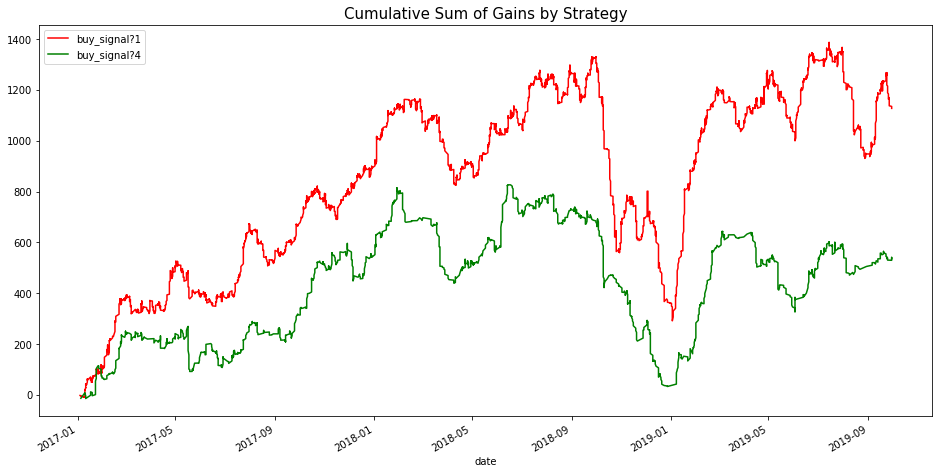

In [420]:
colors = ['red', 'green', 'blue', 'black', 'orange']

fig = plt.figure(figsize=(16,8))

for idx, signal in enumerate(pair_of_signals):
    rgl_df[rgl_df['strategy'] == signal[0]]['$_gain'].cumsum().plot(figsize=(16,8), color=colors[idx], label=signal[0])

plt.legend()
plt.title('Cumulative Sum of Gains by Strategy', size=15);

## Sum of Non Realized Gains

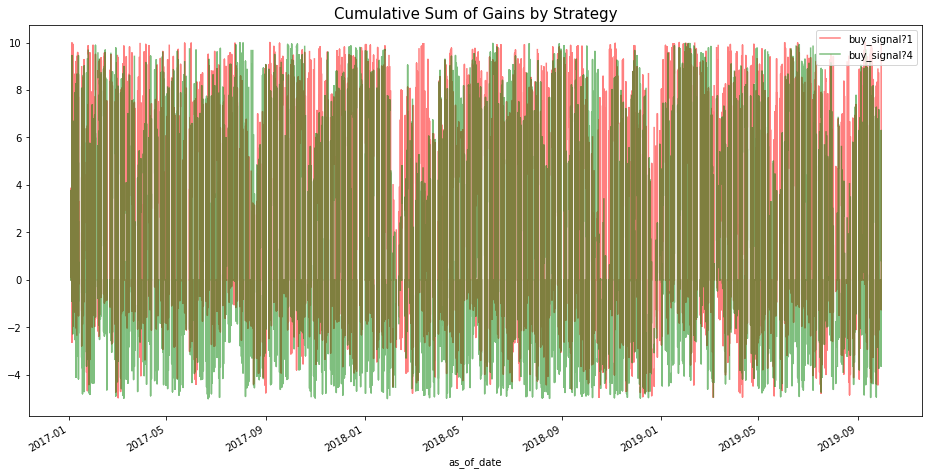

In [421]:
colors = ['red', 'green', 'blue', 'black', 'orange']

fig = plt.figure(figsize=(16,8))

for idx, signal in enumerate(pair_of_signals):
    holdings_df[holdings_df['strategy'] == signal[0]]['$_gain'].plot(figsize=(16,8), color=colors[idx], label=signal[0], alpha=0.5)

plt.legend()
plt.title('Cumulative Sum of Gains by Strategy', size=15);

### Holdings - Cash not Included

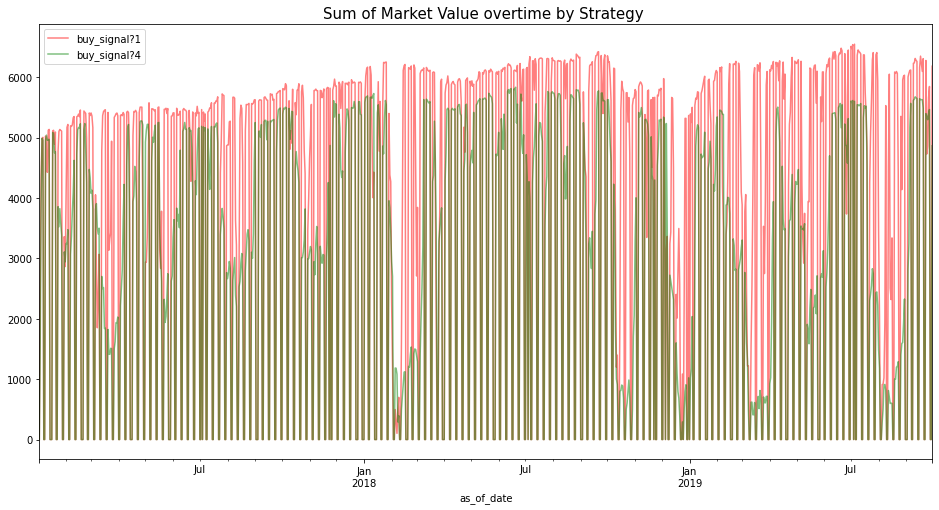

In [422]:
colors = ['red', 'green', 'blue', 'black', 'orange']

fig = plt.figure(figsize=(16,8))

for idx, signal in enumerate(pair_of_signals):
    holdings_df[holdings_df['strategy'] == signal[0]].groupby(level=0).sum()['market_value'].plot(figsize=(16,8), color=colors[idx], label=signal[0], alpha=0.5)

plt.legend()
plt.title('Sum of Market Value overtime by Strategy ', size=15);


## Cash Balance overtime

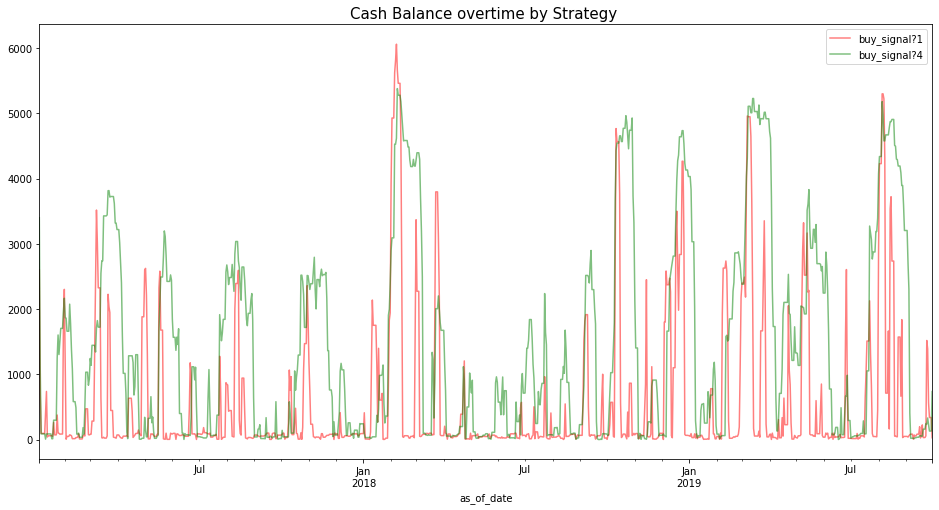

In [423]:
colors = ['red', 'green', 'blue', 'black', 'orange']

fig = plt.figure(figsize=(16,8))

for idx, signal in enumerate(pair_of_signals):
    balances_df[balances_df['strategy'] == signal[0]].groupby(level=0).sum()['market_value'].plot(figsize=(16,8), color=colors[idx], label=signal[0], alpha=0.5)

plt.legend()
plt.title('Cash Balance overtime by Strategy ', size=15);


## Holdings + Cash

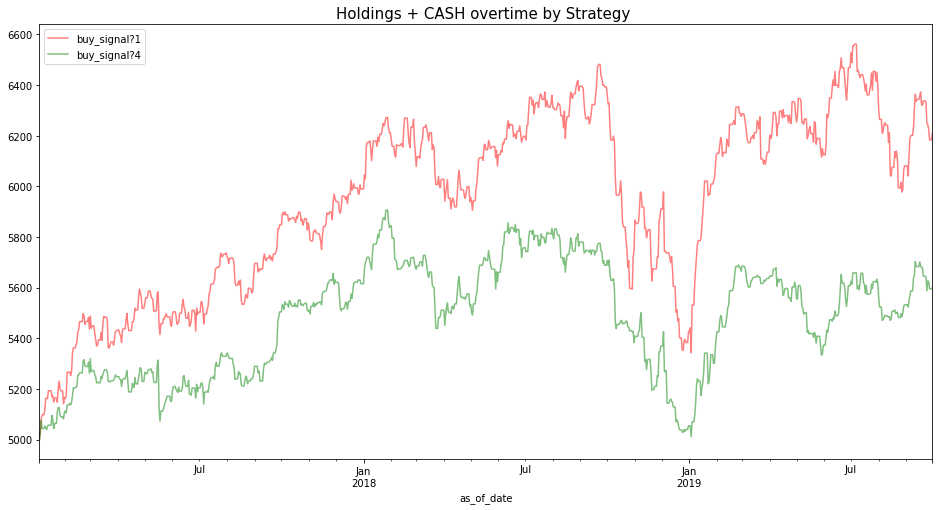

In [424]:
colors = ['red', 'green', 'blue', 'black', 'orange']

fig = plt.figure(figsize=(16,8))

for idx, signal in enumerate(pair_of_signals):
    a = balances_df[balances_df['strategy'] == signal[0]].groupby(level=0).sum()['market_value'].reset_index()
    b = holdings_df[holdings_df['strategy'] == signal[0]].groupby(level=0).sum()['market_value'].reset_index()
    b.replace(0, np.NaN, inplace=True)
    a.columns = ['as_of_date', 'cash_balance']
    plot_me = pd.merge(a,b,how='left', on='as_of_date')
    plot_me['market_value'] = plot_me['market_value'].ffill()
    plot_me.set_index('as_of_date', inplace=True)
    plot_me['total'] = plot_me['cash_balance'] + plot_me['market_value']
    plot_me['total'].plot(figsize=(16,8), color=colors[idx], label=signal[0], alpha=0.5, linestyle = '-')

plt.legend()
plt.title('Holdings + CASH overtime by Strategy ', size=15);


## Invested Money overtime

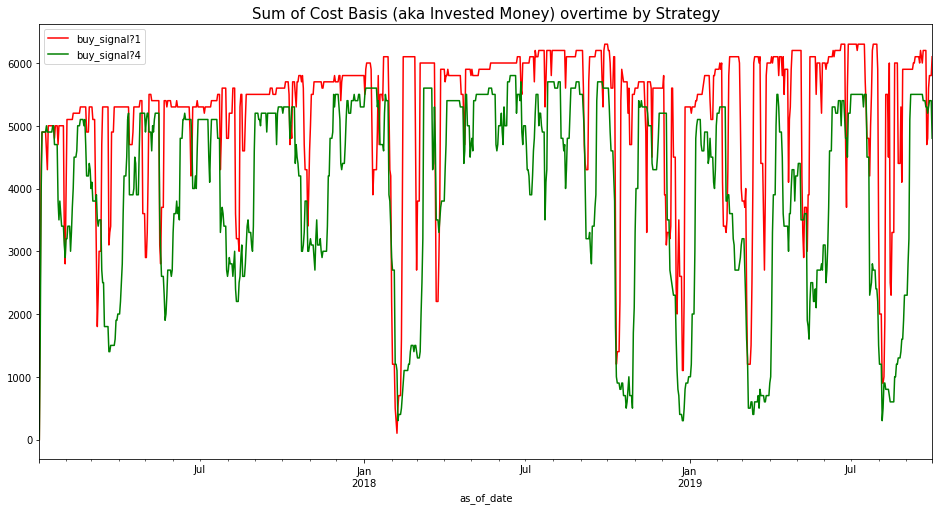

In [425]:
colors = ['red', 'green', 'blue', 'black', 'orange']

fig = plt.figure(figsize=(16,8))

for idx, signal in enumerate(pair_of_signals):
    holdings_df[holdings_df['strategy'] == signal[0]].groupby(level=0).sum()['cost_basis'].plot(figsize=(16,8), color=colors[idx], label=signal[0])

plt.legend()
plt.title('Sum of Cost Basis (aka Invested Money) overtime by Strategy', size=15);

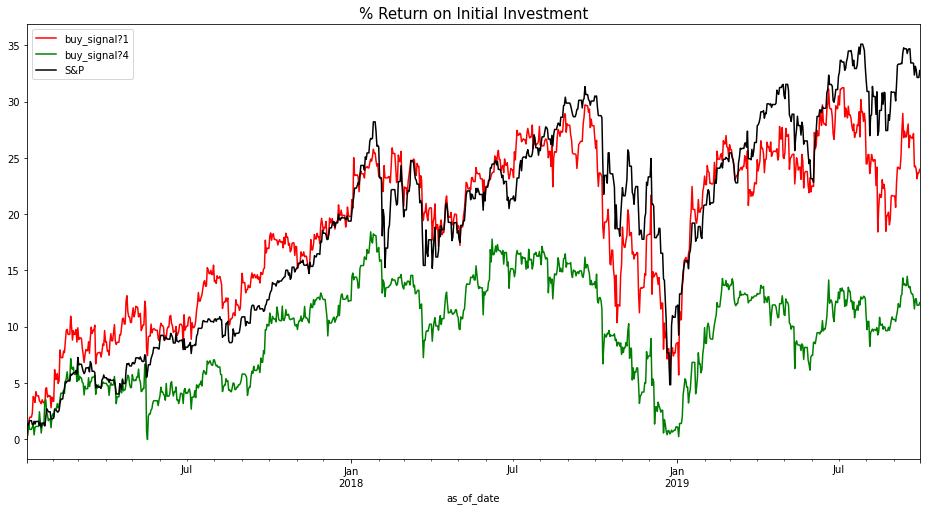

In [426]:
colors = ['red', 'green', 'blue', 'black', 'orange']

for idx, signal in enumerate(pair_of_signals):
    # Calulate gains, current_holdings and balances
    gains = rgl_df[rgl_df['strategy'] == signal[0]].fillna(0).groupby(level=0).sum()['$_gain'].reset_index()
    current_holdings = holdings_df[(holdings_df['strategy'] == signal[0])].groupby(level=0).sum()['market_value'].reset_index().replace(0, np.NaN)
    current_balance = balances_df[(balances_df['strategy'] == signal[0])].groupby(level=0).sum()['market_value'].reset_index()
    
    # Rename columns for balances
    current_balance.columns = ['as_of_date', 'cash_balance']
    
    # Forward Fill
    current_holdings['market_value'] = current_holdings['market_value'].ffill()
    
    # Create data_frame to plot
    to_plot = pd.merge(current_balance, current_holdings, how='left', on='as_of_date')
    to_plot = pd.merge(to_plot, gains, how='left', left_on='as_of_date', right_on='date')
    
    # calculate total
    to_plot.fillna(0, inplace=True)
    to_plot['%_return'] = 100*(((to_plot['$_gain'] + to_plot['market_value'] + to_plot['cash_balance']) / 5000) - 1)
    to_plot.set_index('as_of_date', inplace=True)
    
    to_plot['%_return'].plot(figsize=(16,8), color=colors[idx], label=signal[0])
    
# benchmark
to_plot_sp = pd.merge(to_plot, sp, left_index=True, right_index=True, how='left')
to_plot_sp['daily_returns'] = to_plot_sp['daily_returns'].fillna(1)
to_plot_sp['running_return'] = (to_plot_sp['daily_returns'].cumprod() - 1) * 100
to_plot_sp['running_return'].plot(figsize=(16,8), color='black', label='S&P')
    
plt.legend()
plt.title('% Return on Initial Investment', size=15);
    

In [349]:
to_plot

cash_balance  market_value                 date      $_gain  \
as_of_date                                                                
2017-01-03   3400.000000   1600.000000                    0    0.000000   
2017-01-04   1100.000000   3924.996638                    0    0.000000   
2017-01-05     95.987286   4979.300817  2017-01-05 00:00:00   -4.012714   
2017-01-06     95.987286   4949.941883                    0    0.000000   
2017-01-07     95.987286   4949.941883                    0    0.000000   
2017-01-08     95.987286   4949.941883                    0    0.000000   
2017-01-09     14.432603   5060.491579  2017-01-09 00:00:00   18.445317   
2017-01-10     36.272367   5031.381466  2017-01-10 00:00:00   21.839764   
2017-01-11     15.557036   5043.159472  2017-01-11 00:00:00  -20.715331   
2017-01-12     23.557037   5048.860626  2017-01-12 00:00:00    8.000001   
2017-01-13     23.557037   5052.716681                    0    0.000000   
2017-01-14     23.557037   5052.716681                    0    0.000000   
2017-01-15     23.557037   5052.716681                    0    0.000000   
2017-01-16     23.557037   5052.716681                    0    0.000000   
2017-01-17     31.626836   5070.796473  2017-01-17 00:00:00    8.069799   
2017-01-18     31.626836   5055.645226                    0    0.000000   
2017-01-19    229.559705   4823.303018  2017-01-19 00:00:00   -2.067131   
2017-01-20    326.402637   4750.280108  2017-01-20 00:00:00   -3.157068   
2017-01-21    326.402637   4750.280108                    0    0.000000   
2017-01-22    326.402637   4750.280108                    0    0.000000   
2017-01-23   1277.552916   3841.842439  2017-01-23 00:00:00   51.150279   
2017-01-24   1514.667371   3620.397572  2017-01-24 00:00:00   37.114455   
2017-01-25   1214.667371   3916.076046                    0    0.000000   
2017-01-26   1014.667371   4081.851745                    0    0.000000   
2017-01-27   1017.323951   4065.599593  2017-01-27 00:00:00    2.656580   
2017-01-28   1017.323951   4065.599593                    0    0.000000   
2017-01-29   1017.323951   4065.599593                    0    0.000000   
2017-01-30    716.411315   4359.213110  2017-01-30 00:00:00   -0.912636   
2017-01-31    711.287350   4398.995086  2017-01-31 00:00:00   -5.123964   
2017-02-01    311.287350   4783.693626                    0    0.000000   
2017-02-02    111.287350   5004.502248                    0    0.000000   
2017-02-03     21.169351   5132.905150  2017-02-03 00:00:00    9.882001   
2017-02-04     21.169351   5132.905150                    0    0.000000   
2017-02-05     21.169351   5132.905150                    0    0.000000   
2017-02-06    844.436938   4310.280711  2017-02-06 00:00:00   23.267586   
2017-02-07    546.277428   4605.231066  2017-02-07 00:00:00    1.840490   
2017-02-08    362.095379   4807.385347  2017-02-08 00:00:00   15.817951   
2017-02-09    649.081187   4562.233374  2017-02-09 00:00:00  -13.014192   
2017-02-10    257.697373   4982.217814  2017-02-10 00:00:00    8.616186   
2017-02-11    257.697373   4982.217814                    0    0.000000   
2017-02-12    257.697373   4982.217814                    0    0.000000   
2017-02-13    592.622984   4658.356770  2017-02-13 00:00:00   34.925610   
2017-02-14      0.819260   5241.206978  2017-02-14 00:00:00    8.196277   
2017-02-15     12.857374   5277.340088  2017-02-15 00:00:00   12.038114   
2017-02-16     12.857374   5296.360747                    0    0.000000   
2017-02-17     25.562837   5296.109170  2017-02-17 00:00:00   12.705463   
2017-02-18     25.562837   5296.109170                    0    0.000000   
2017-02-19     25.562837   5296.109170                    0    0.000000   
2017-02-20     25.562837   5296.109170                    0    0.000000   
2017-02-21    800.944304   4570.564996  2017-02-21 00:00:00   75.381467   
2017-02-22    224.955965   5147.592506  2017-02-22 00:00:00   24.011661   
2017-02-23    223.765878   5120.33149

In [340]:
rgl_df[rgl_df['$_gain'] > 0].groupby('strategy').count()['as_of_date'] / rgl_df[rgl_df['$_gain'] < 0].groupby('strategy').count()['as_of_date']

strategy
buy_signal?1    1.249689
buy_signal?4    1.207317
Name: as_of_date, dtype: float64

In [266]:
balances_df.tail()

strategy  market_value symbol
as_of_date                                   
2017-09-28  buy_signal?4     76.236156   CASH
2017-09-29  buy_signal?1     80.525608   CASH
2017-09-29  buy_signal?4     95.475508   CASH
2017-09-30  buy_signal?1     80.525608   CASH
2017-09-30  buy_signal?4     95.475508   CASH

In [305]:
big_losses = rgl_df[(rgl_df['strategy'] == 'buy_signal?1') & (rgl_df['%_gain'] < - 0.15)][['strategy', 'buy_date', 
                                                                                           'symbol', 'cost_per_unit']]
big_wins = rgl_df[(rgl_df['strategy'] == 'buy_signal?1') & (rgl_df['%_gain'] > 0.15)][['strategy', 'buy_date', 
                                                                                           'symbol', 'cost_per_unit']]

In [306]:
all_holdings = holdings_df[holdings_df['strategy'] == 'buy_signal?1'].reset_index()
neg_analysis_df =  pd.merge(all_holdings, big_losses, on =['strategy', 'buy_date', 'symbol', 'cost_per_unit'])
pos_analysis_df =  pd.merge(all_holdings, big_wins, on =['strategy', 'buy_date', 'symbol', 'cost_per_unit'])

In [307]:
big_losses

strategy             buy_date symbol  cost_per_unit
date                                                               
2017-02-23  buy_signal?1  2017-02-22 00:00:00     LB      58.130001

In [308]:
big_wins

strategy             buy_date symbol  cost_per_unit
date                                                               
2017-01-10  buy_signal?1  2017-01-04 00:00:00   SRPT      29.240000
2017-04-06  buy_signal?1  2017-03-24 00:00:00    SUN      24.370001
2017-07-05  buy_signal?1  2017-06-05 00:00:00   NVRO      71.160004

In [274]:
rgl_df[(rgl_df['strategy'] == 'buy_signal?1') & (rgl_df['%_gain'] < - 0.15)]

strategy             buy_date symbol  cost_per_unit    shares  \
date                                                                            
2017-01-31  buy_signal?1  2017-01-04 00:00:00    UAA      30.540001  3.274394   
2017-02-03  buy_signal?1  2017-01-03 00:00:00   DECK      57.509998  1.738828   
2017-02-23  buy_signal?1  2017-02-03 00:00:00     LB      59.580002  1.678416   
2017-02-23  buy_signal?1  2017-02-06 00:00:00     LB      59.150002  1.690617   
2017-08-04  buy_signal?1  2017-07-14 00:00:00   SYNA      55.090000  1.815211   
2017-08-15  buy_signal?1  2017-07-31 00:00:00    DKS      37.340000  2.678093   

            cost_basis as_of_date  day_close_price order_type      price  \
date                                                                       
2017-01-31       100.0 2017-01-31        21.490000       sell  21.490000   
2017-02-03       100.0 2017-02-03        46.619999       sell  46.619999   
2017-02-23       100.0 2017-02-23        48.939999       sell  48.939999   
2017-02-23       100.0 2017-02-23        48.939999       sell  48.939999   
2017-08-04       100.0 2017-08-04        45.320000       sell  45.320000   
2017-08-15       100.0 2017-08-15        26.870001       sell  26.870001   

            sell_date  market_value     $_gain    %_gain  
date                                                      
2017-01-31 2017-01-31     70.366729 -29.633271 -0.296333  
2017-02-03 2017-02-03     81.064163 -18.935837 -0.189358  
2017-02-23 2017-02-23     82.141653 -17.858347 -0.178583  
2017-02-23 2017-02-23     82.738795 -17.261205 -0.172612  
2017-08-04 2017-08-04     82.265383 -17.734617 -0.177346  
2017-08-15 2017-08-15     71.960366 -28.039634 -0.280396

In [249]:
pos_analysis_df

as_of_date      strategy             buy_date symbol  cost_per_unit  \
0    2017-01-03  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
1    2017-01-04  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
2    2017-01-05  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
3    2017-01-06  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
4    2017-01-07  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
5    2017-01-08  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
6    2017-01-09  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
7    2017-01-10  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
8    2017-01-11  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
9    2017-01-12  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
10   2017-01-13  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
11   2017-01-14  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
12   2017-01-15  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
13   2017-01-16  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
14   2017-01-17  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
15   2017-01-18  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
16   2017-01-19  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
17   2017-01-20  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
18   2017-01-21  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
19   2017-01-22  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
20   2017-01-23  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
21   2017-01-24  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
22   2017-01-25  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
23   2017-01-26  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
24   2017-01-27  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
25   2017-01-28  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
26   2017-01-29  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
27   2017-01-30  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
28   2017-01-31  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
29   2017-02-01  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
30   2017-02-02  buy_signal?1  2017-01-03 00:00:00    UHS     106.709999   
31   2017-01-03  buy_signal?1  2017-01-03 00:00:00   PRAH      55.369999   
32   2017-01-04  buy_signal?1  2017-01-03 00:00:00   PRAH      55.369999   
33   2017-01-05  buy_signal?1  2017-01-03 00:00:00   PRAH      55.369999   
34   2017-01-06  buy_signal?1  2017-01-03 00:00:00   PRAH      55.369999   
35   2017-01-07  buy_signal?1  2017-01-03 00:00:00   PRAH      55.369999   
36   2017-01-08  buy_signal?1  2017-01-03 00:00:00   PRAH      55.369999   
37   2017-01-09  buy_signal?1  2017-01-03 00:00:00   PRAH      55.369999   
38   2017-01-10  buy_signal?1  2017-01-03 00:00:00   PRAH      55.369999   
39   2017-01-11  buy_signal?1  2017-01-03 00:00:00   PRAH      55.369999   
40   2017-01-12  buy_signal?1  2017-01-03 00:00:00   PRAH      55.369999   
41   2017-01-13  buy_signal?1  2017-01-03 00:00:00   PRAH      55.369999   
42   2017-01-14  buy_signal?1  2017-01-03 00:00:00   PRAH      55.369999   
43   2017-01-15  buy_signal?1  2017-01-03 00:00:00   PRAH      55.369999   
44   2017-01-16  buy_signal?1  2017-01-03 00:00:00   PRAH      55.369999   
45   2017-01-17  buy_signal?1  2017-01-03 00:00:00   PRAH      55.369999   
46   2017-01-18  buy_signal?1  2017-01-03 00:00:00   PRAH      55.369999   
47   2017-01-19  buy_signal?1  2017-01-03 00:00:00   PRAH      55.369999   
48   2017-01-20  buy_signal?1  2017-01-03 00:00:00   PRAH      55.369999   
49   2017-01-21  buy_signal?1  2017-01-03 00:00:00   PRAH      55.369999   
50   2017-01-22  buy_signal?1  2017-01-03 00:00:00   PRAH      55.369999   
51   2017-01-23  buy_signal?1  2017-01-03 00:00:00   


# Export

In [70]:
total = rgl_df.groupby(['strategy', 'symbol']).count()['as_of_date'].reset_index()
positive = rgl_df[rgl_df['$_gain'] > 0].groupby(['strategy', 'symbol']).count()['as_of_date'].reset_index()
total.columns = ['strategy', 'symbol', 'total']
positive.columns = ['strategy', 'symbol', 'positive']

In [36]:
ddd = pd.merge(total, positive, on=['strategy', 'symbol'], how='left')
ddd['ratio'] = ddd['positive'] / ddd['total']

In [39]:
ddd[ddd['strategy'] == 'buy_signal?4'].sort_values('total', ascending=False)

strategy symbol  total  positive     ratio
1313  buy_signal?4   SBNY     12       8.0  0.666667
1062  buy_signal?4    EIX     10       4.0  0.400000
1425  buy_signal?4    WRI      9       5.0  0.555556
1352  buy_signal?4   SYNA      9       7.0  0.777778
1353  buy_signal?4   SYNH      9       4.0  0.444444
1030  buy_signal?4    CPB      9       NaN       NaN
1183  buy_signal?4    LPL      8       6.0  0.750000
1338  buy_signal?4     SO      8       2.0  0.250000
998   buy_signal?4    BXS      8       5.0  0.625000
1001  buy_signal?4    CBD      8       4.0  0.500000
1311  buy_signal?4   SAIC      8       7.0  0.875000
1188  buy_signal?4    LSI      8       1.0  0.125000
1247  buy_signal?4    NWS      8       8.0  1.000000
1343  buy_signal?4    SRE      8       8.0  1.000000
1346  buy_signal?4   STMP      7       7.0  1.000000
1321  buy_signal?4   SGEN      7       5.0  0.714286
1320  buy_signal?4    SFM      7       6.0  0.857143
1363  buy_signal?4   TERP      7       6.0  0.857143
904   buy_signal?4   AAXN      7       6.0  0.857143
1039  buy_signal?4    CVI      7       7.0  1.000000
1264  buy_signal?4   PANW      6       6.0  1.000000
1306  buy_signal?4    RPM      6       6.0  1.000000
1307  buy_signal?4    RUN      6       5.0  0.833333
1110  buy_signal?4   GOLF      6       NaN       NaN
1380  buy_signal?4    TTC      6       4.0  0.666667
1064  buy_signal?4    ELP      6       6.0  1.000000
999   buy_signal?4    CAH      6       6.0  1.000000
1009  buy_signal?4    CFR      6       6.0  1.000000
1259  buy_signal?4   OTEX      6       1.0  0.166667
958   buy_signal?4     AU      6       1.0  0.166667
1243  buy_signal?4   NUVA      6       4.0  0.666667
1241  buy_signal?4   NTES      6       6.0  1.000000
1372  buy_signal?4    TPX      5       NaN       NaN
965   buy_signal?4    AYI      5       3.0  0.600000
1218  buy_signal?4   MTSI      5       3.0  0.600000
1216  buy_signal?4    MSM      5       3.0  0.600000
1330  buy_signal?4    SKM      5       NaN       NaN
1169  buy_signal?4     KT      5       2.0  0.400000
981   buy_signal?4   BKNG      5       1.0  0.200000
980   buy_signal?4    BKH      5       NaN       NaN
1319  buy_signal?4     SF      5       5.0  1.000000
1389  buy_signal?4    UHS      5       1.0  0.200000
1283  buy_signal?4   PRAH      5       3.0  0.600000
1050  buy_signal?4    DKS      5       1.0  0.200000
1245  buy_signal?4    NWE      5       5.0  1.000000
1246  buy_signal?4    NWL      5       2.0  0.400000
1198  buy_signal?4    MDU      5       4.0  0.800000
1119  buy_signal?4   HAIN      5       2.0  0.400000
1305  buy_signal?4   ROST      5       3.0  0.600000
912   buy_signal?4   ACIW      5       NaN       NaN
1224  buy_signal?4   NATI      5       1.0  0.200000
1020  buy_signal?4     CM      5       5.0  1.000000
1289  buy_signal?4   PZZA      5       1.0  0.200000
977   buy_signal?4    BHP      4       1.0  0.250000
1339  buy_signal?4   SPLK      4       1.0  0.250000
1212  buy_signal?4   MOMO      4       1.0  0.250000
1204  buy_signal?4    MKC      4       4.0  1.000000
1209  buy_signal?4   MNTA      4       3.0  0.750000
1054  buy_signal?4    DOC      4       NaN       NaN
1308  buy_signal?4  RYAAY      4       3.0  0.750000
1177  buy_signal?4   LITE      4       3.0  0.750000
1094  buy_signal?4    FLO      4       4.0  1.000000
1202  buy_signal?4    MHK      4       4.0  1.000000
1000  buy_signal?4   CATY      4       3.0  0.750000
1005  buy_signal?4    CCJ      4       4.0  1.000000
1053  buy_signal?4   DNKN      4       1.0  0.250000
1342  buy_signal?4   SRCL      4       3.0  0.750000
1019  buy_signal?4    CLX      4       NaN       NaN
1021  buy_signal?4  CMCSA      4       NaN       NaN
1022  buy_signal?4    CMG      4       1.0  0.250000
1079  buy_signal?4    EXP      4       1.0  0.250000
1240  buy_signal?4   NTCT      4       NaN       NaN
1291  buy_signal?4   QDEL      4       4.0  1.000000
1329  buy_signal?4    SJR      4       2.0  0.500000
1159  buy_signal?4   JCOM      4   

In [371]:
rgl_df[(rgl_df['strategy'] == 'buy_signal?1') & (rgl_df['$_gain'] < 0)].sort_values('$_gain')

strategy             buy_date symbol  cost_per_unit  \
date                                                                  
2020-05-04  buy_signal?1  2020-04-29 00:00:00   BBDO       3.500000   
2020-04-02  buy_signal?1  2020-04-01 00:00:00   GRUB      39.580002   
2020-04-27  buy_signal?1  2020-04-23 00:00:00    IFS      26.410000   
2020-05-12  buy_signal?1  2020-05-07 00:00:00    TCO      43.950001   
2020-06-03  buy_signal?1  2020-06-02 00:00:00    VIR      37.029999   
2020-05-19  buy_signal?1  2020-05-18 00:00:00    TEF       4.740000   
2020-04-24  buy_signal?1  2020-04-21 00:00:00    GSX      34.669998   
2020-05-04  buy_signal?1  2020-05-01 00:00:00  EBR-B       5.070000   
2020-05-29  buy_signal?1  2020-05-27 00:00:00    ABM      33.500000   
2020-05-19  buy_signal?1  2020-05-18 00:00:00    SAN       2.120000   
2020-04-03  buy_signal?1  2020-04-01 00:00:00    EXP      54.189999   
2020-05-04  buy_signal?1  2020-04-30 00:00:00   BBDO       3.290000   
2020-04-16  buy_signal?1  2020-04-15 00:00:00   GBDC      11.810000   
2020-05-01  buy_signal?1  2020-04-29 00:00:00      E      19.480000   
2020-04-03  buy_signal?1  2020-04-02 00:00:00    WSO     158.179993   
2020-05-14  buy_signal?1  2020-05-12 00:00:00    GIL      13.840000   
2020-04-03  buy_signal?1  2020-04-01 00:00:00    WSO     157.970001   
2020-05-01  buy_signal?1  2020-04-29 00:00:00     HE      40.830002   
2020-05-13  buy_signal?1  2020-05-07 00:00:00     MC      29.790001   
2020-05-13  buy_signal?1  2020-05-07 00:00:00    SCI      37.759998   
2020-05-13  buy_signal?1  2020-05-07 00:00:00   ALLE     100.139999   
2020-05-19  buy_signal?1  2020-05-18 00:00:00      M       5.420000   
2020-05-04  buy_signal?1  2020-04-29 00:00:00   NTCT      27.250000   
2020-05-05  buy_signal?1  2020-04-28 00:00:00    BXS      21.559999   
2020-05-13  buy_signal?1  2020-05-11 00:00:00   MKSI     100.570000   
2020-05-20  buy_signal?1  2020-05-18 00:00:00    GPS       7.820000   
2020-04-03  buy_signal?1  2020-04-02 00:00:00   FIBK      28.600000   
2020-04-03  buy_signal?1  2020-04-02 00:00:00    ABM      24.240000   
2020-04-13  buy_signal?1  2020-04-01 00:00:00   PINC      33.029999   
2020-04-16  buy_signal?1  2020-04-14 00:00:00   VRNS      63.919998   
2020-06-01  buy_signal?1  2020-05-29 00:00:00    SNP      47.529999   
2020-05-29  buy_signal?1  2020-05-26 00:00:00    AGO      27.420000   
2020-04-20  buy_signal?1  2020-04-17 00:00:00   UHAL     275.250000   
2020-04-21  buy_signal?1  2020-04-20 00:00:00    SCI      39.220001   
2020-05-19  buy_signal?1  2020-05-18 00:00:00   ITUB       3.980000   
2020-04-15  buy_signal?1  2020-04-14 00:00:00   ALEC      23.490000   
2020-04-21  buy_signal?1  2020-04-17 00:00:00   NEOG      66.070000   
2020-04-23  buy_signal?1  2020-04-22 00:00:00   PFGC      24.990000   
2020-05-13  buy_signal?1  2020-05-06 00:00:00    SCI      37.189999   
2020-05-01  buy_signal?1  2020-04-27 00:00:00   AIZP     109.470001   
2020-05-13  buy_signal?1  2020-05-12 00:00:00   ENSG      38.349998   
2020-05-12  buy_signal?1  2020-05-07 00:00:00   TGNA      10.920000   
2020-04-17  buy_signal?1  2020-04-15 00:00:00    CZZ      12.430000   
2020-04-21  buy_signal?1  2020-04-20 00:00:00     WK      33.580002   
2020-05-01  buy_signal?1  2020-04-30 00:00:00    ACH       5.290000   
2020-05-01  buy_signal?1  2020-04-30 00:00:00   FCFS      71.839996   
2020-04-30  buy_signal?1  2020-04-29 00:00:00    GGG      46.709999   
2020-05-13  buy_signal?1  2020-05-11 00:00:00     CM      59.529999   
2020-05-13  buy_signal?1  2020-05-06 00:00:00    AXS      36.330002   
2020-05-13  buy_signal?1  2020-05-12 00:00:00     HP      18.420000   
2020-05-01  buy_signal?1  2020-04-29 00:00:00   COKE     242.529999   
2020-04-21  buy_signal?1  2020-04-20 00:00:00   INGR      80.800003   
2020-04-15  buy_signal?1  2020-04-07 00:00:00   SFBS      29.129999   
2020-05-19  buy_signal?1  2020-05-18 00:00:00    CIT      16.270000   
2020-04-20  buy_signal?1  2020-04-17 00:

In [246]:
rgl_df.reset_index().to_feather('../output/rgl.feather')

In [201]:
rgl_df[rgl_df['strategy'] == 'buy_signal?4']['market_value']

date
2017-04-13     88.484721
2017-04-17     93.293210
2017-04-26     97.090782
2017-04-26     98.279231
2017-04-26    102.744813
2017-04-26     99.354382
2017-04-26    128.571421
2017-04-28     90.592332
2017-04-28     89.041094
2017-04-28     91.228070
2017-04-28     84.017493
2017-04-28     93.965699
2017-04-28     92.100470
2017-04-28     92.909690
2017-05-01     96.502443
2017-05-01    103.662596
2017-05-01    105.393743
2017-05-03     73.761226
2017-05-08     90.806758
2017-05-08     93.436299
2017-05-08     93.256264
2017-05-08     94.163430
2017-05-17     86.904761
2017-05-18     96.054803
2017-05-19     89.882355
2017-05-19     90.736347
2017-05-19     91.223882
2017-05-19     96.020763
2017-05-22     93.340385
2017-05-23    139.682538
2017-05-25    117.161289
2017-05-31     86.366515
2017-06-05     89.142854
2017-06-06    101.818177
2017-06-06    100.298503
2017-06-09    135.287353
2017-06-12    100.152617
2017-06-12    100.574711
2017-06-12    100.000000
2017-06-14    102.12